# Comparisons with AWI IceBird 2019

**Summary:** In this notebook, we produce comparisons of winter ICESat-2 and CryoSat-2 sea ice thickness data with snow depth and sea ice thickness data from the airborne IceBird 2019 campaign.
 
**Version history**: Version 1 (05/01/2025)

# Import notebook dependencies

In [1]:
import xarray as xr 
import pandas as pd
import numpy as np
import itertools
import pyproj 
from netCDF4 import Dataset
import scipy.interpolate 
from utils.read_data_utils import read_book_data, read_IS2SITMOGR4 # Helper function for reading the data from the bucket
from utils.plotting_utils import compute_gridcell_winter_means, interactiveArcticMaps, interactive_winter_mean_maps, interactive_winter_comparison_lineplot # Plotting
from extra_funcs import apply_interpolation_timestep
from scipy import stats
import datetime
# Plotting dependencies
import cartopy.crs as ccrs
from textwrap import wrap
import hvplot.pandas
import holoviews as hv
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh # Helps avoid some weird issues with the polar projection 
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl

# Interpolating/smoothing packages 
from scipy.interpolate import griddata
from scipy.spatial import KDTree
from astropy.convolution import convolve
from astropy.convolution import Gaussian2DKernel

mpl.rcParams['figure.dpi'] = 200 # Sets figure size in the notebook

# Remove warnings to improve display
import warnings 
warnings.filterwarnings('ignore') 


In [2]:
mpl.rcParams.update({
    "font.size": 7,  # Match typical LaTeX 10pt font
    "axes.labelsize": 7,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
    "legend.fontsize": 7
})

In [3]:
grid_size=100
ib_agg_str='mean'
int_str='_int'

# Define the variables to compare
variables_ice = [
    'ice_thickness'+int_str,
    'ice_thickness_sm'+int_str, 
    'ice_thickness_mw99'+int_str, 
    'ice_thickness_j22'+int_str, 
    'ice_thickness_cs2_ubris'
]

# Define the variables to compare
variables_snow = [
    'snow_depth'+int_str, 
    'snow_depth_sm'+int_str, 
    'snow_depth_mw99'+int_str, 
    'cs2is2_snow_depth'
]

variables_all = variables_ice+variables_snow

In [4]:
# Load the all-season wrangled dataset
IS2SITMOGR4_v3 = xr.open_dataset('./data/book_data_allseason.nc')
print("Successfully loaded all-season wrangled dataset")

Successfully loaded all-season wrangled dataset


In [5]:
out_proj = 'EPSG:3411'
out_lons = IS2SITMOGR4_v3.longitude.values
out_lats = IS2SITMOGR4_v3.latitude.values

mapProj = pyproj.Proj("+init=" + out_proj)
xptsIS2, yptsIS2 = mapProj(out_lons, out_lats)

In [6]:
# Just select April as that's all we use here
IS2SITMOGR4_v3 = IS2SITMOGR4_v3.sel(time='2019-04-15')

In [7]:
# COARSEN TO MATCH 100 KM RESOLUTION OF IB
if grid_size==100:
    # First count valid values in each block
    valid_counts = IS2SITMOGR4_v3.notnull().coarsen(y=4, x=4, boundary='trim').sum()
    
    # Calculate means
    means = IS2SITMOGR4_v3.coarsen(y=4, x=4, boundary='trim').mean()
    
    # Mask means where count is less than minimum
    IS2SITMOGR4_v3 = means.where(valid_counts >= 4)

IS2SITMOGR4_v3

<xarray.Dataset>
Dimensions:                         (y: 112, x: 76)
Coordinates:
    time                            datetime64[ns] 2019-04-15
  * x                               (x) float32 -3.8e+06 -3.7e+06 ... 3.7e+06
  * y                               (y) float32 5.8e+06 5.7e+06 ... -5.3e+06
    longitude                       (y, x) float32 168.2 167.5 ... -10.81 -10.08
    latitude                        (y, x) float32 31.47 31.85 ... 35.27 34.85
Data variables: (12/47)
    crs                             float64 nan
    ice_thickness_sm                (y, x) float32 nan nan nan ... nan nan nan
    ice_thickness_unc               (y, x) float32 nan nan nan ... nan nan nan
    num_segments                    (y, x) float32 nan nan nan ... nan nan nan
    mean_day_of_month               (y, x) float32 nan nan nan ... nan nan nan
    snow_depth_sm                   (y, x) float32 nan nan nan ... nan nan nan
    ...                              ...
    ice_density_j22_int             (y, x) float32 nan nan nan ... nan nan nan
    ice_thickness_j22_int           (y, x) float32 nan nan nan ... nan nan nan
    ice_thickness_cs2_ubris         (y, x) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    cs2_sea_ice_type_UBRIS          (y, x) float64 nan nan nan ... nan nan nan
    cs2_sea_ice_density_UBRIS       (y, x) float64 nan nan nan ... nan nan nan
    cs2is2_snow_depth               (y, x) float64 nan nan nan ... nan nan nan
Attributes:
    contact:      Alek Petty (akpetty@umd.edu)
    description:  Aggregated IS2SITMOGR4 summer V0 dataset.
    history:      Created 20/12/23

In [8]:
# Mask data where the CS-2 thickness data is nan to make comps fair/same grid-cells
IS2SITMOGR4_v3 = IS2SITMOGR4_v3.where(~np.isnan(IS2SITMOGR4_v3.ice_thickness_cs2_ubris))

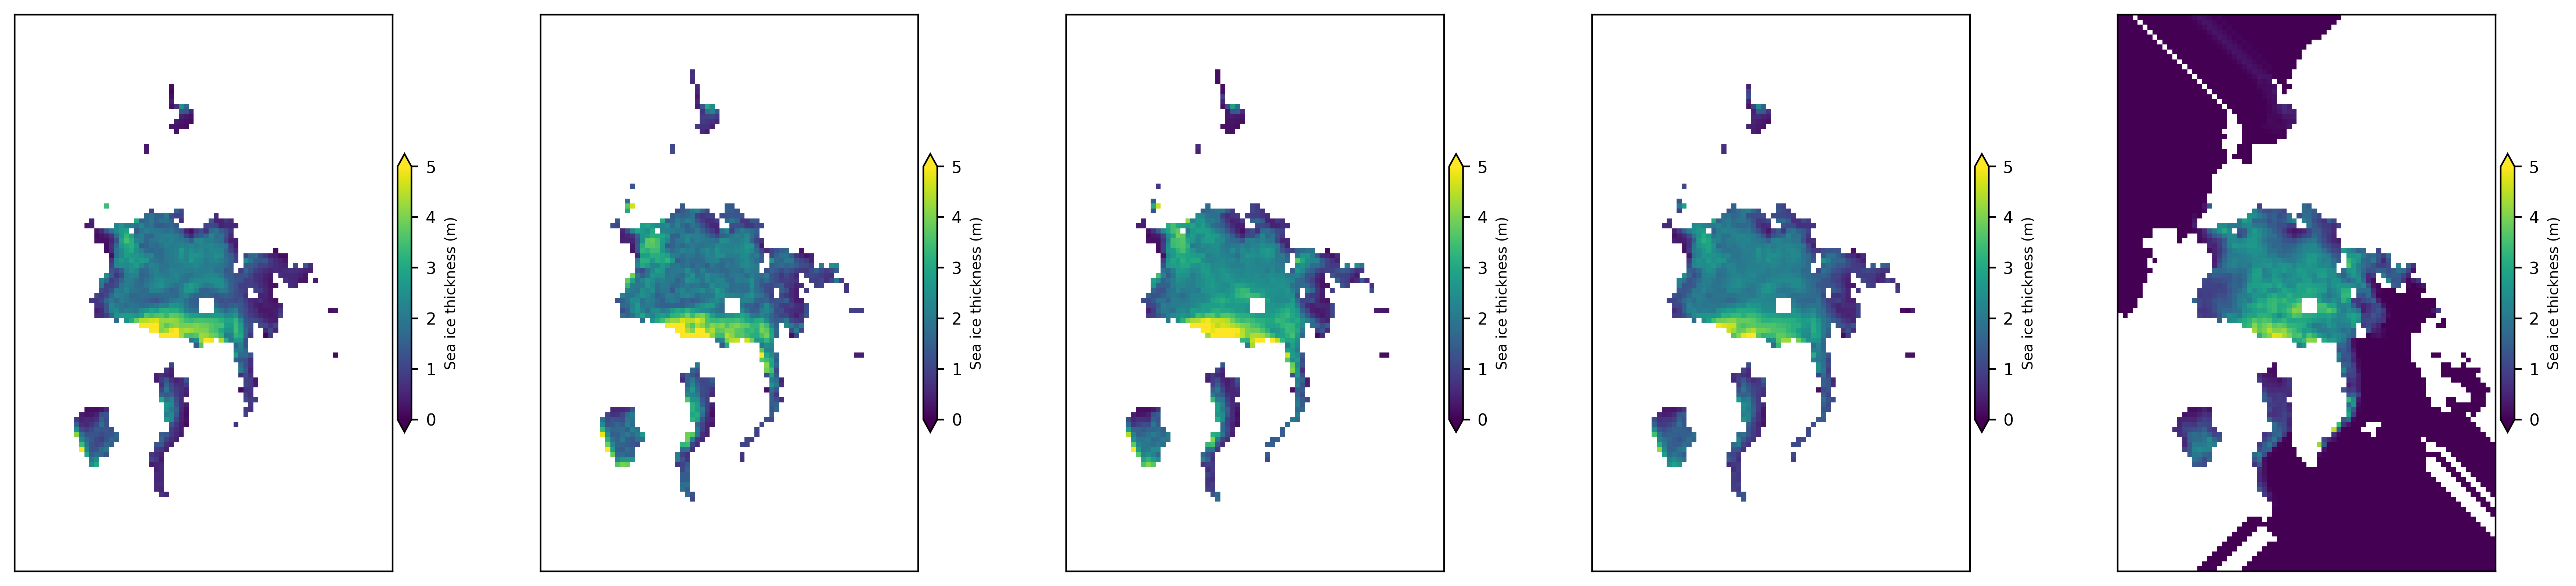

In [9]:
# See how things look
# The CS-2 data looks janky but that's just weird interpoaltion issues far away from the regions we care about..
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(18, 4))
i=0

# Iterate over each variable and plot it
for ax, var in zip(axes, variables_ice):
    im = ax.imshow(IS2SITMOGR4_v3[var].values, 
                  cmap="viridis",
                  vmin=0, vmax=5,
                  aspect='equal')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, pad=0.01, shrink=0.5, extend='both')
    cbar.set_label('Sea ice thickness (m)')
    cbar.ax.tick_params(labelsize=8)
    
    # Remove axis labels since this is a grid
    ax.set_xticks([])
    ax.set_yticks([])
    
    i+=1

plt.tight_layout()
plt.show()
plt.close()

In [10]:
# Open the IB NetCDF file
file_path = '/Users/akpetty/Data/IS2-obs-comparison-data/icebird_on_is2_grid_'+str(grid_size)+'km_test1.nc'
dataset = xr.open_dataset(file_path)
dataset = dataset.rename({'date': 'time'})
dataset = dataset.transpose('y', 'x', 'time')
print(dataset)

<xarray.Dataset>
Dimensions:                   (x: 76, y: 112, time: 5)
Coordinates:
    lon                       (y, x) float64 ...
    lat                       (y, x) float64 ...
  * x                         (x) float64 -3.838e+06 -3.738e+06 ... 3.662e+06
  * y                         (y) float64 5.838e+06 5.738e+06 ... -5.262e+06
  * time                      (time) datetime64[ns] 2019-04-02 ... 2019-04-10
    crs                       int32 ...
Data variables:
    sea_ice_thickness_mean    (y, x, time) float64 ...
    sea_ice_thickness_median  (y, x, time) float64 ...
    sea_ice_thickness_mode    (y, x, time) float64 ...
    sea_ice_thickness_count   (y, x, time) float64 ...
    snow_thickness_mean       (y, x, time) float64 ...
    snow_thickness_median     (y, x, time) float64 ...
    snow_thickness_mode       (y, x, time) float64 ...
    snow_thickness_count      (y, x, time) float64 ...


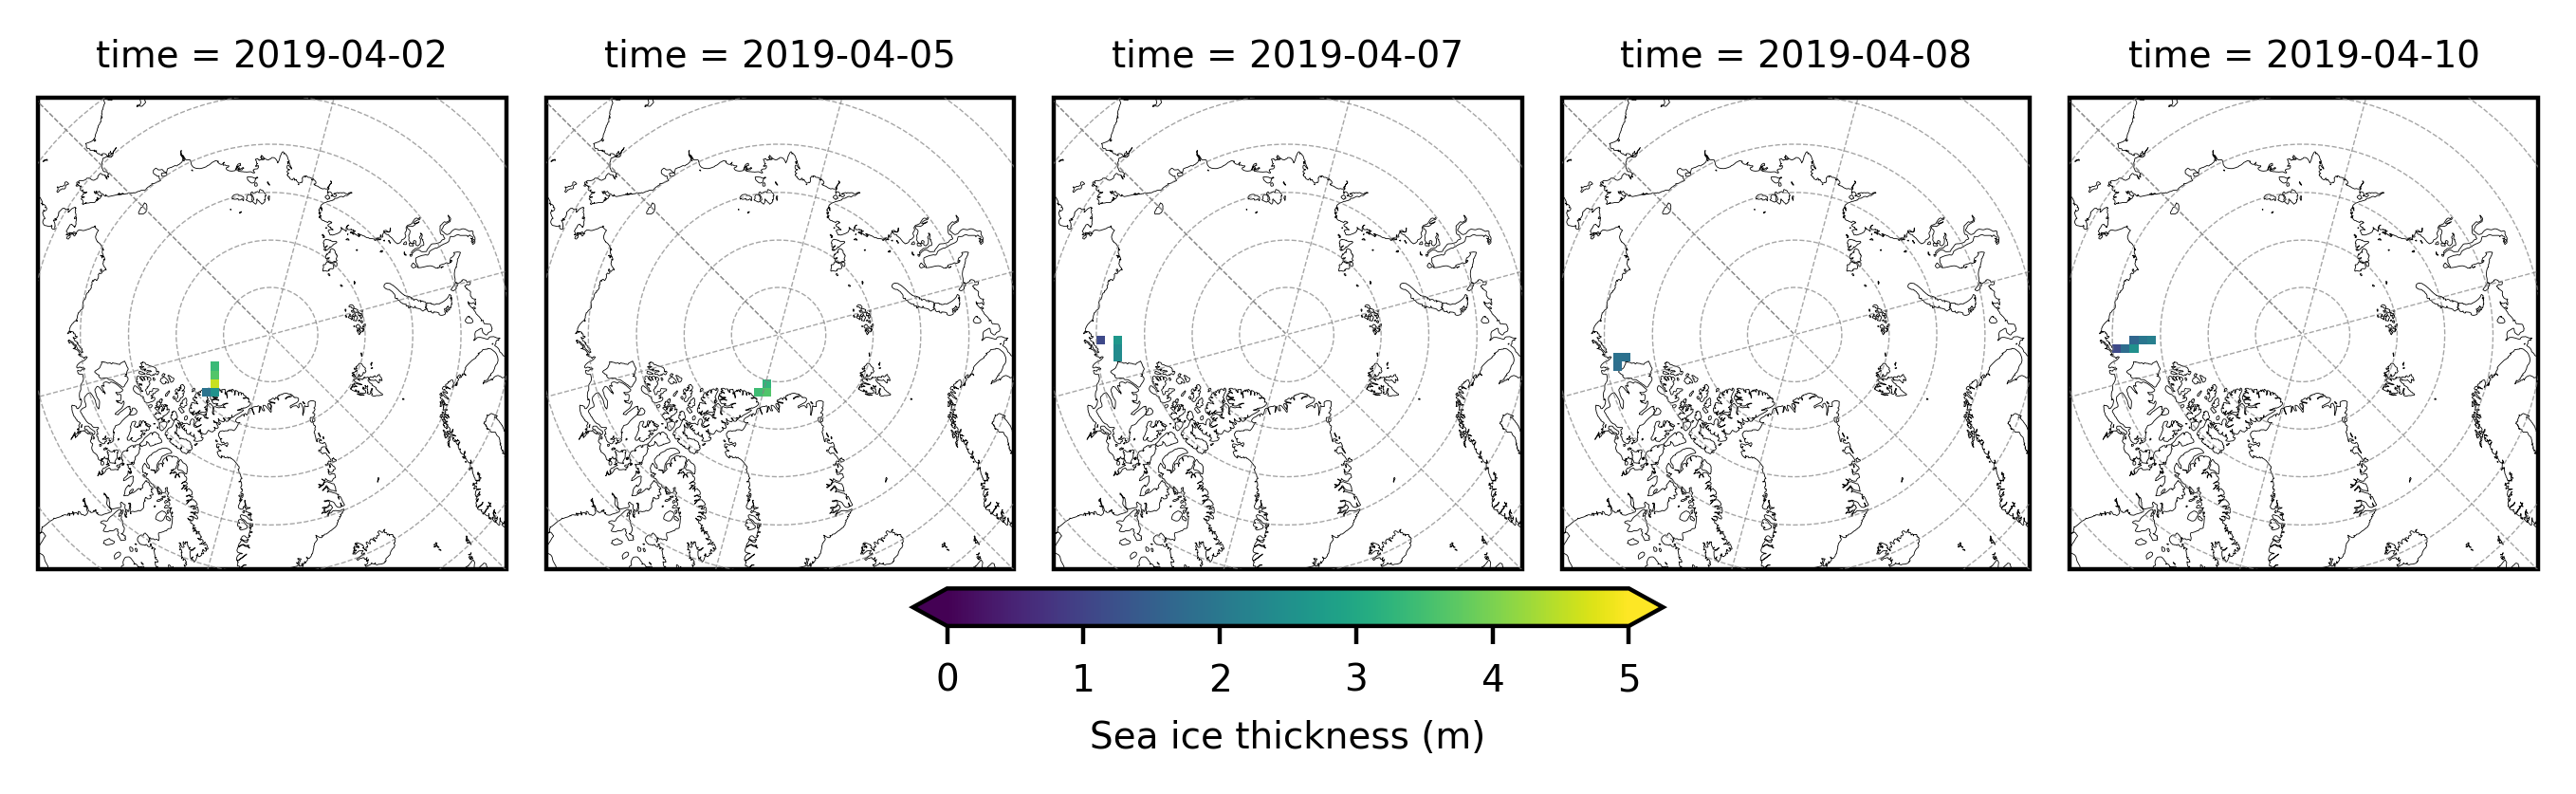

In [11]:
# Plot out the gridded IB data by day
fig_width=6.8
fig_height=5.4

im1 = dataset.sea_ice_thickness_mean.plot(x="lon", y="lat", col='time', transform=ccrs.PlateCarree(), 
                       cmap="viridis", zorder=3, add_labels=False,
                       subplot_kws={'projection':ccrs.NorthPolarStereo(central_longitude=-45)},
                       cbar_kwargs={'pad':0.01,'shrink': 0.3,'extend':'both', 
                                  'label':'Sea ice thickness (m)', 'location':'bottom'},
                       vmin=0, vmax=5,
                       figsize=(fig_width, fig_height))


# Add map features to all subplots
i=0
for i, ax in enumerate(im1.axes.flatten()):
    ax.coastlines(linewidth=0.15, color='black', zorder=2)
    #ax.add_feature(cfeature.LAND, color='0.95', zorder=1)
    ax.gridlines(draw_labels=False, linewidth=0.25, color='gray', alpha=0.7, linestyle='--', zorder=3)
    ax.set_extent([-179, 179, 65, 90], crs=ccrs.PlateCarree())
    #ax.text(0.02, 0.93, panel_letters[i], transform=ax.transAxes, fontsize=7, va='bottom', ha='left')
    #ax.set_title('', fontsize=8)
    i+=1

#plt.subplots_adjust(wspace=0.01) 
#plt.savefig('./figs/maps_summer_thickness_comparison.png', dpi=300, facecolor="white")
plt.show()
plt.close()

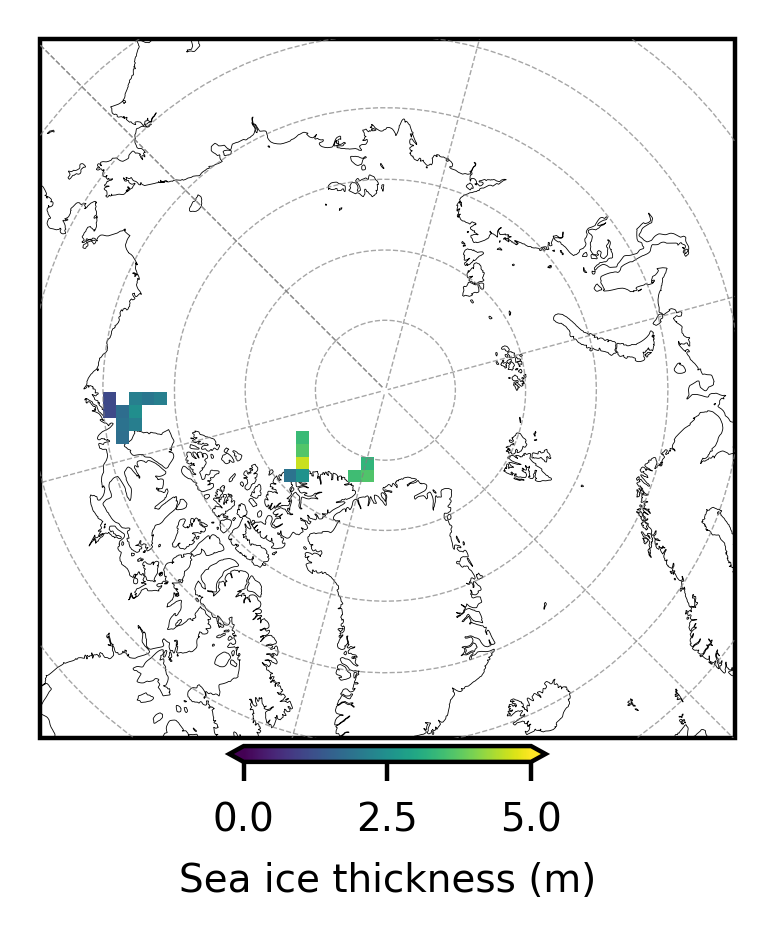

In [12]:
# Plot out the gridded IB data by campaign
fig_width=3.4
fig_height=2.7

im1 = dataset.sea_ice_thickness_mean.mean(dim='time').plot(x="lon", y="lat",  transform=ccrs.PlateCarree(), 
                       cmap="viridis", zorder=3, add_labels=False,
                       subplot_kws={'projection':ccrs.NorthPolarStereo(central_longitude=-45)},
                       cbar_kwargs={'pad':0.01,'shrink': 0.3,'extend':'both', 
                                  'label':'Sea ice thickness (m)', 'location':'bottom'},
                       vmin=0, vmax=5,
                       figsize=(fig_width, fig_height))

# Add map features to the single subplot
ax = im1.axes  # Access the single axis object
ax.coastlines(linewidth=0.15, color='black', zorder=2)
ax.gridlines(draw_labels=False, linewidth=0.25, color='gray', alpha=0.7, linestyle='--', zorder=3)
ax.set_extent([-179, 179, 65, 90], crs=ccrs.PlateCarree())
#plt.subplots_adjust(wspace=0.01) 
plt.savefig('./figs/IBmap_all'+str(grid_size)+'km.png', dpi=300, facecolor="white")
plt.show()
plt.close()

In [13]:

# Initialize a dictionary to store validation results
validation_results = {}

# Calculate statistics and generate scatter plots for each variable
for var in variables_ice:
    # Calculate statistics
    IS2_var = IS2SITMOGR4_v3[var]
    IB_var = dataset['sea_ice_thickness_'+ib_agg_str].mean(dim='time') 
    IB_lon = dataset['lon']  
    valid_mask = ~np.isnan(IS2_var.values) & ~np.isnan(IB_var.values)
    IB_comps=IB_var.where(valid_mask).values.flatten()[~np.isnan(IB_var.where(valid_mask).values.flatten())]
    IB_lon=IB_lon.where(valid_mask).values.flatten()[~np.isnan(IB_var.where(valid_mask).values.flatten())]*-1.
    IS2_comps=IS2_var.where(valid_mask).values.flatten()[~np.isnan(IS2_var.where(valid_mask).values.flatten())]

    # Correlation Coeff
    correlation = '%.02f' % (np.corrcoef(IS2_comps, IB_comps)[0, 1])
    # Calculate mean bias
    mean_bias = '%.02f' % (np.mean(IS2_comps - IB_comps))
    # Calculate standard dev of differences
    std_dev = '%.02f' % (np.std(IS2_comps - IB_comps))
    # Calculate RMSE    
    rmse = '%.02f' % (np.sqrt(np.mean((IS2_comps - IB_comps) ** 2)))
    
    # Store results
    validation_results[var] = {
        'r_str': correlation, 'mb_str': mean_bias, 'sd_str': std_dev, 
        'rmse': rmse, 'IB_comps': IB_comps, 'IS2_comps': IS2_comps,
        'IB_lon': IB_lon
    }

# Print validation results
print(validation_results)

{'ice_thickness_int': {'r_str': '0.93', 'mb_str': '0.16', 'sd_str': '0.83', 'rmse': '0.85', 'IB_comps': array([1.09604872, 2.14618237, 1.95420074, 2.14831064, 1.12813711,
       1.76287681, 2.44654497, 3.39757853, 3.64979042, 4.58394392,
       3.2632371 , 3.45273987, 3.62678507]), 'IS2_comps': array([0.63818747, 2.2361875 , 2.3706875 , 1.9508749 , 0.65368754,
       0.94862497, 1.6961875 , 4.1224375 , 5.2204614 , 5.9924164 ,
       4.2799377 , 2.388     , 4.2235003 ], dtype=float32), 'IB_lon': array([133.32516201, 133.15238973, 133.05191499, 132.93988898,
       130.65254309, 130.44004991, 130.20576793, 105.37625125,
        99.0394828 ,  93.57633437,  58.73626831,  64.72227776,
        56.72511202])}, 'ice_thickness_sm_int': {'r_str': '0.89', 'mb_str': '0.43', 'sd_str': '0.71', 'rmse': '0.83', 'IB_comps': array([1.09604872, 2.14618237, 1.95420074, 2.14831064, 1.12813711,
       1.76287681, 2.44654497, 3.39757853, 3.64979042, 4.58394392,
       3.2632371 , 3.45273987, 3.62678507]), 'I

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


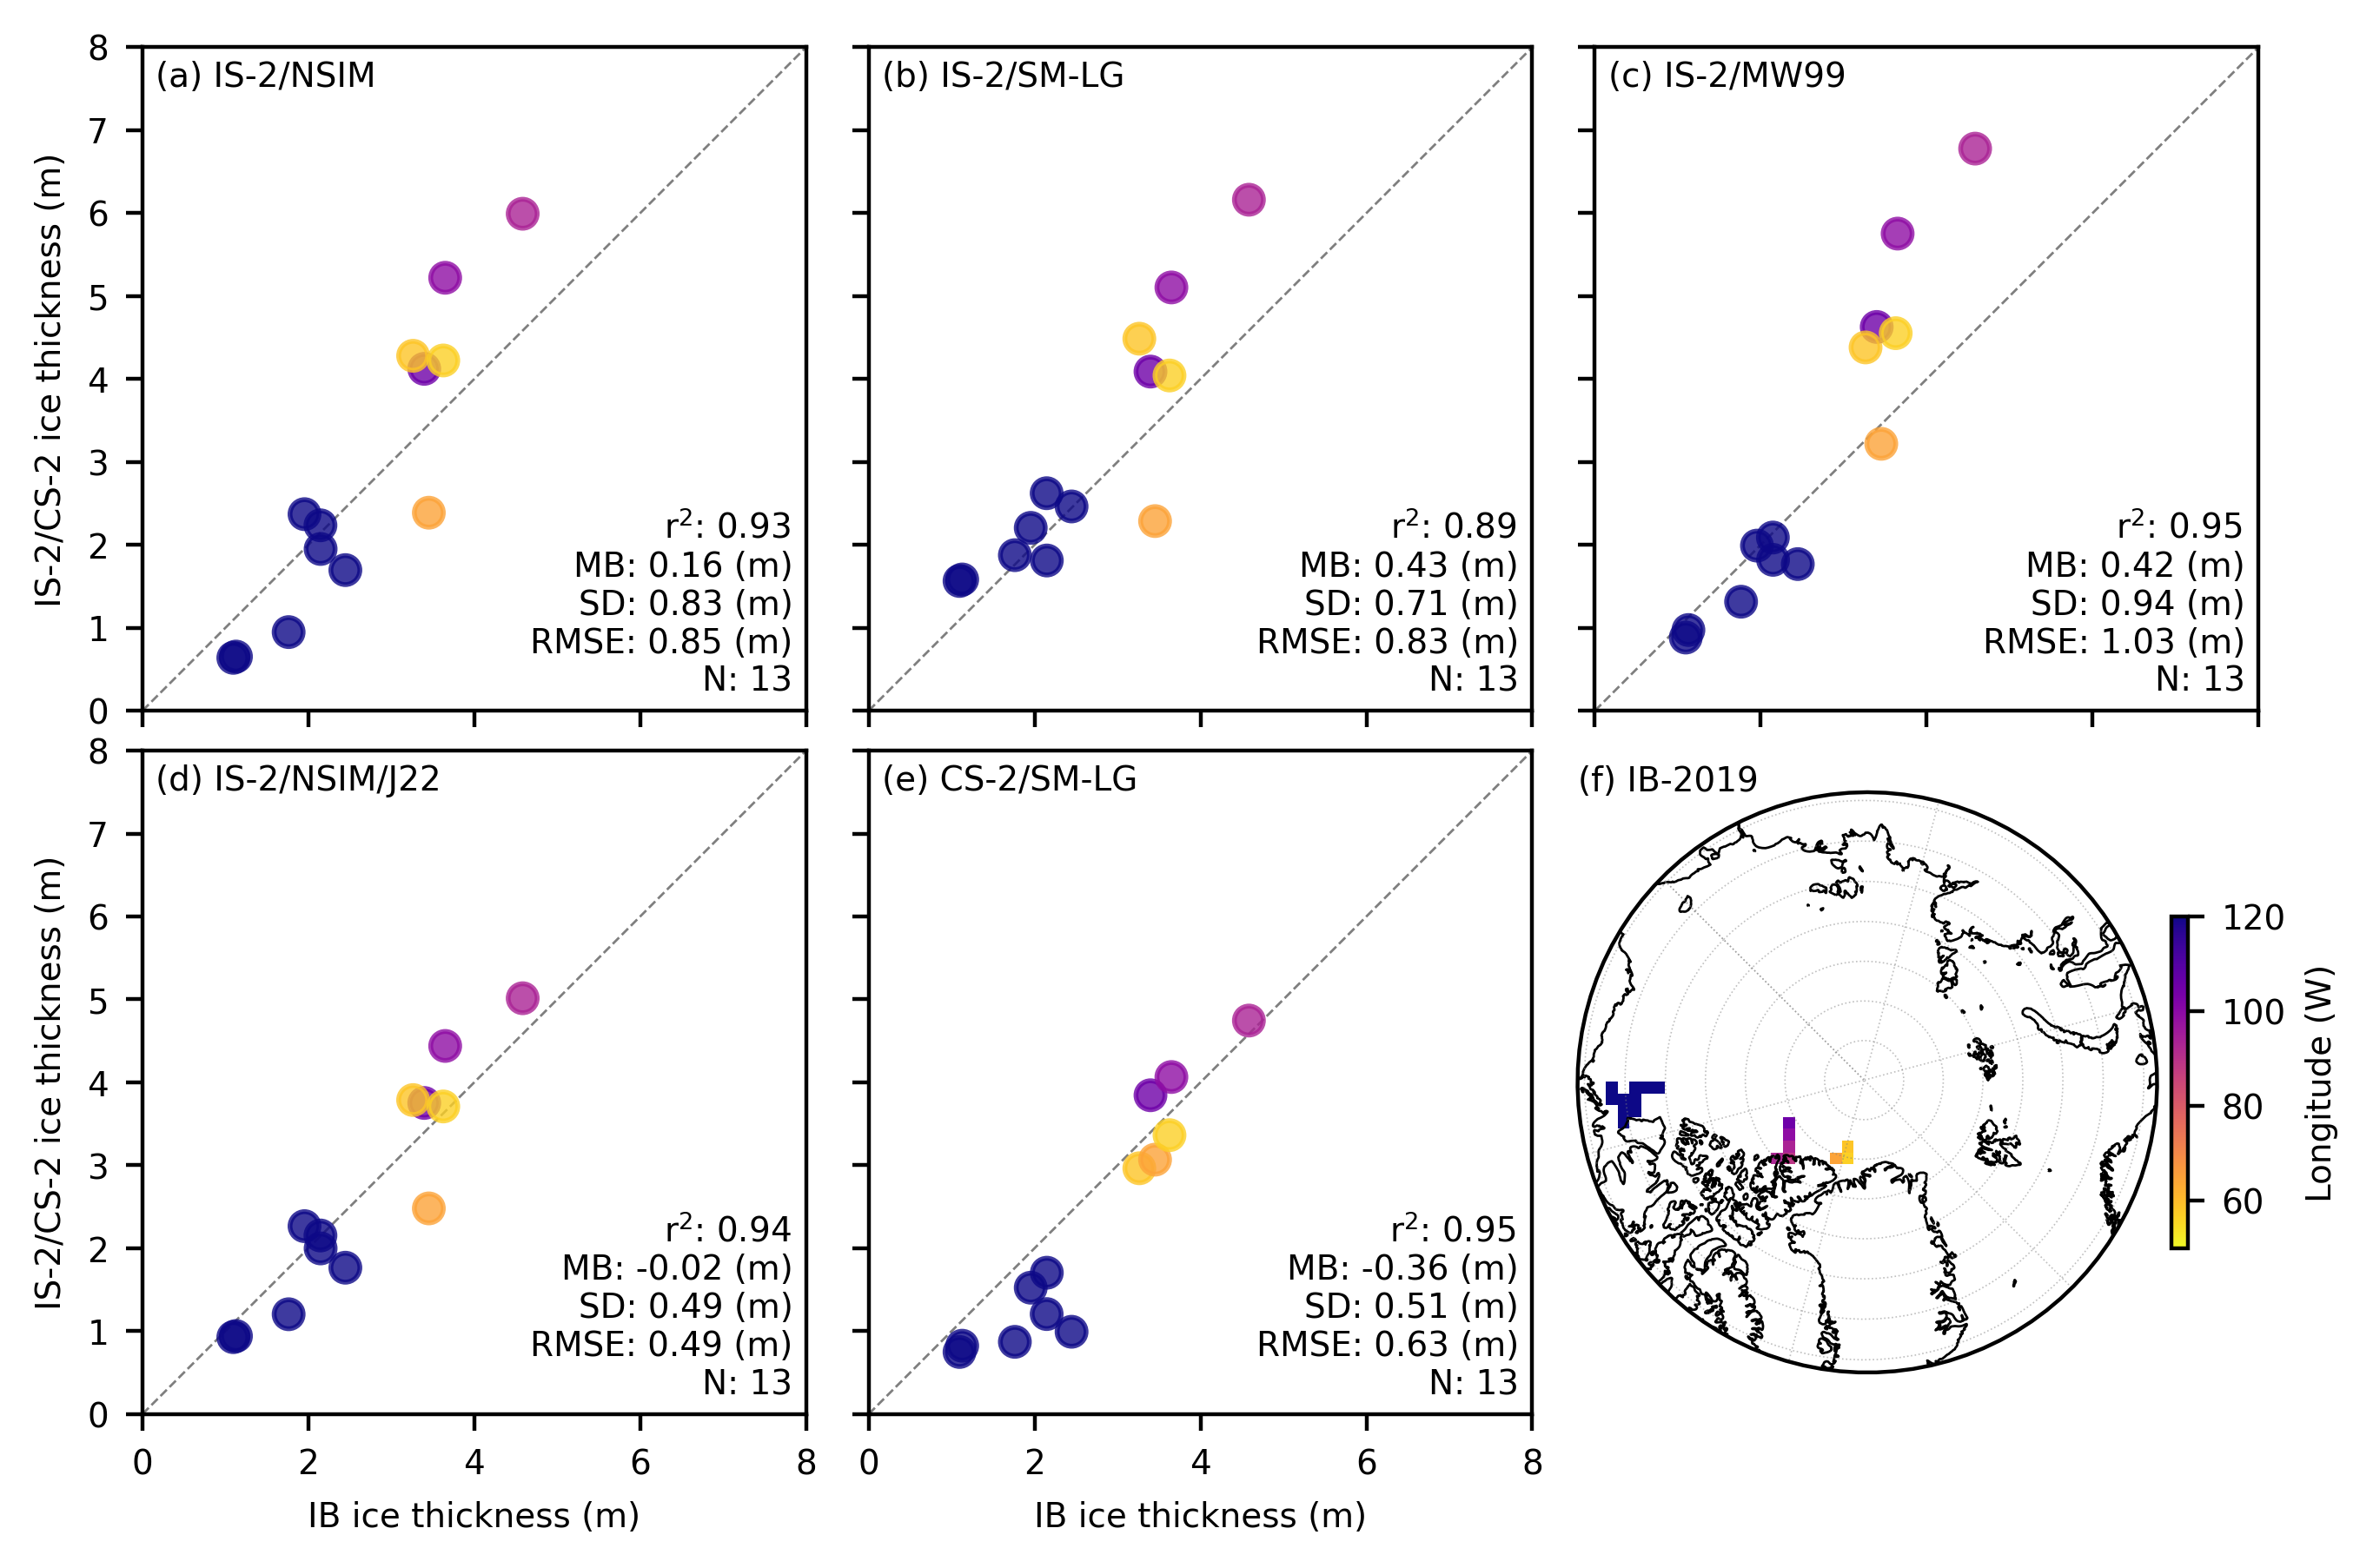

In [14]:

fig = plt.figure(figsize=(6.8, 6.8*0.65))
gs = fig.add_gridspec(2, 3, hspace=0.06, wspace=0.04)

axes = []
for i in range(2):
    for j in range(3):
        if i == 1 and j == 2:
            # Create the cartopy map in the third position
            ax = fig.add_subplot(gs[i, j], projection=ccrs.NorthPolarStereo(central_longitude=-45))
        else:
            ax = fig.add_subplot(gs[i, j])
        axes.append(ax)

panel_labels = ['(a) IS-2/NSIM', '(b) IS-2/SM-LG', '(c) IS-2/MW99', '(d) IS-2/NSIM/J22', '(e) CS-2/SM-LG', '(f) IB-2019']

#panel_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']  # Panel labels

# Configure the cartopy map in the third subplot
map_ax = axes[5]
map_ax.set_extent([-180, 180, 68, 90], crs=ccrs.PlateCarree())
map_ax.coastlines(resolution='50m', color='black', linewidth=0.5)
map_ax.gridlines(draw_labels=False, linewidth=0.3, color='gray', alpha=0.5, linestyle=':')

# Add a circular boundary for the polar plot
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpl.path.Path(verts * radius + center)
map_ax.set_boundary(circle, transform=map_ax.transAxes)

# Plot IceBird flight tracks or data locations
# Example: Plot the locations of the IceBird measurements
im = map_ax.pcolormesh(
    dataset.x, 
    dataset.y, 
    -1.*dataset.lon.where(np.isfinite(dataset.sea_ice_thickness_mean.mean(dim='time'))), 
    transform=ccrs.NorthPolarStereo(central_longitude=-45),
    cmap='plasma_r',
    vmin=50, 
    vmax=120  # Adjust the range as needed
)
cbar = plt.colorbar(im, ax=map_ax, orientation='vertical', pad=0.02, shrink=0.5)
cbar.set_label('Longitude (W)', fontsize=7)

# Add panel label
map_ax.annotate(f"{panel_labels[5]}", xy=(0.0, 0.99), 
                xycoords='axes fraction', 
                horizontalalignment='left', 
                verticalalignment='bottom')

# Process the other subplots as before
for i, option in enumerate(variables_ice):
    ax_idx = i
    
    ax = axes[ax_idx]
    im = ax.scatter(validation_results[option]['IB_comps'], validation_results[option]['IS2_comps'], 
                   c=validation_results[option]['IB_lon'], alpha=0.8, cmap='plasma_r', vmin=50, vmax=120)

    # Retrieve validation results for the current option
    r_str = validation_results[option]['r_str']
    mb_str = validation_results[option]['mb_str']
    sd_str = validation_results[option]['sd_str']
    n_str = str(len(validation_results[option]['IS2_comps']))

    # Calculate RMSE for each ULS
    rmse = validation_results[option]['rmse']

    # Annotate the plot with statistics
    ax.annotate(f"r$^2$: {r_str} \nMB: {mb_str} (m)\nSD: {sd_str} (m)\nRMSE: {rmse} (m)\nN: {n_str}", 
                color='k', xy=(0.98, 0.02), xycoords='axes fraction', 
                horizontalalignment='right', verticalalignment='bottom', fontsize=7)

    # Combine panel label with option label
    ax.annotate(f"{panel_labels[ax_idx]} ", xy=(0.02, 0.98), 
                xycoords='axes fraction', horizontalalignment='left', verticalalignment='top')

    # Set x and y labels only for the leftmost and bottom plots
    if (ax_idx == 0):
        ax.legend(frameon=False, loc="upper right")
    if (ax_idx == 0) or (ax_idx == 3):
        ax.set_ylabel('IS-2/CS-2 ice thickness (m)')
    else:
        ax.set_yticklabels('')
    if ax_idx >= 3:
        ax.set_xlabel('IB ice thickness (m)')
    else:
        ax.set_xlabel('')
        ax.set_xticklabels('')

    ax.set_xlim([0, 8])
    ax.set_ylim([0, 8])
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    ax.plot(lims, lims, 'k--', linewidth=0.5, alpha=0.5, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)

plt.subplots_adjust(left=0.05, right=0.96, top=0.98, bottom=0.09)  # Adjust these values to reduce whitespace

plt.savefig('./figs/IB_scatter_inccs2_'+ib_agg_str+'_'+int_str+'_'+str(grid_size)+'km.pdf', dpi=300)
plt.show()

In [15]:
# Initialize a dictionary to store validation results
validation_results_snow = {}

# Calculate statistics and generate scatter plots for each variable
for var in variables_snow:
    # Calculate statistics
    print(var)
    IS2_var = IS2SITMOGR4_v3[var]
    IB_var = dataset['snow_thickness_'+ib_agg_str].mean(dim='time')
    IB_lon = dataset['lon']    
    valid_mask = ~np.isnan(IS2_var.values) & ~np.isnan(IB_var.values)
    IB_lon=IB_lon.where(valid_mask).values.flatten()[~np.isnan(IB_var.where(valid_mask).values.flatten())]*-1.
    IB_comps=IB_var.where(valid_mask).values.flatten()[~np.isnan(IB_var.where(valid_mask).values.flatten())]
    IS2_comps=IS2_var.where(valid_mask).values.flatten()[~np.isnan(IS2_var.where(valid_mask).values.flatten())]

    # Correlation Coeff
    correlation = '%.02f' % (np.corrcoef(IS2_comps, IB_comps)[0, 1])
    # Calculate mean bias
    mean_bias = '%.02f' % (np.mean(IS2_comps - IB_comps))
    # Calculate standard dev of differences
    std_dev = '%.02f' % (np.std(IS2_comps - IB_comps))
    # Calculate RMSE    
    rmse = '%.02f' % (np.sqrt(np.mean((IS2_comps - IB_comps) ** 2)))
    
    # Store results
    validation_results_snow[var] = {
        'r_str': correlation, 'mb_str': mean_bias, 'sd_str': std_dev, 'rmse': rmse, 
        'IB_comps': IB_comps, 'IS2_comps': IS2_comps, 'IB_lon': IB_lon
    }

# Print validation results
print(validation_results_snow)

snow_depth_int
snow_depth_sm_int
snow_depth_mw99_int
cs2is2_snow_depth
{'snow_depth_int': {'r_str': '0.88', 'mb_str': '0.06', 'sd_str': '0.05', 'rmse': '0.08', 'IB_comps': array([0.08393886, 0.162617  , 0.1761535 , 0.19351885, 0.0611693 ,
       0.12320611, 0.19135242, 0.36910769, 0.35409994, 0.36129619,
       0.32445472, 0.24597048, 0.29041957]), 'IS2_comps': array([0.1814375 , 0.18725   , 0.17300001, 0.1885    , 0.198     ,
       0.21175002, 0.2096875 , 0.39662498, 0.41761538, 0.43558335,
       0.33362502, 0.3956875 , 0.3606875 ], dtype=float32), 'IB_lon': array([133.32516201, 133.15238973, 133.05191499, 132.93988898,
       130.65254309, 130.44004991, 130.20576793, 105.37625125,
        99.0394828 ,  93.57633437,  58.73626831,  64.72227776,
        56.72511202])}, 'snow_depth_sm_int': {'r_str': '0.92', 'mb_str': '0.03', 'sd_str': '0.08', 'rmse': '0.08', 'IB_comps': array([0.08393886, 0.162617  , 0.1761535 , 0.19351885, 0.0611693 ,
       0.12320611, 0.19135242, 0.36910769, 0.3540

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


snow_depth_int
snow_depth_sm_int
snow_depth_mw99_int
cs2is2_snow_depth


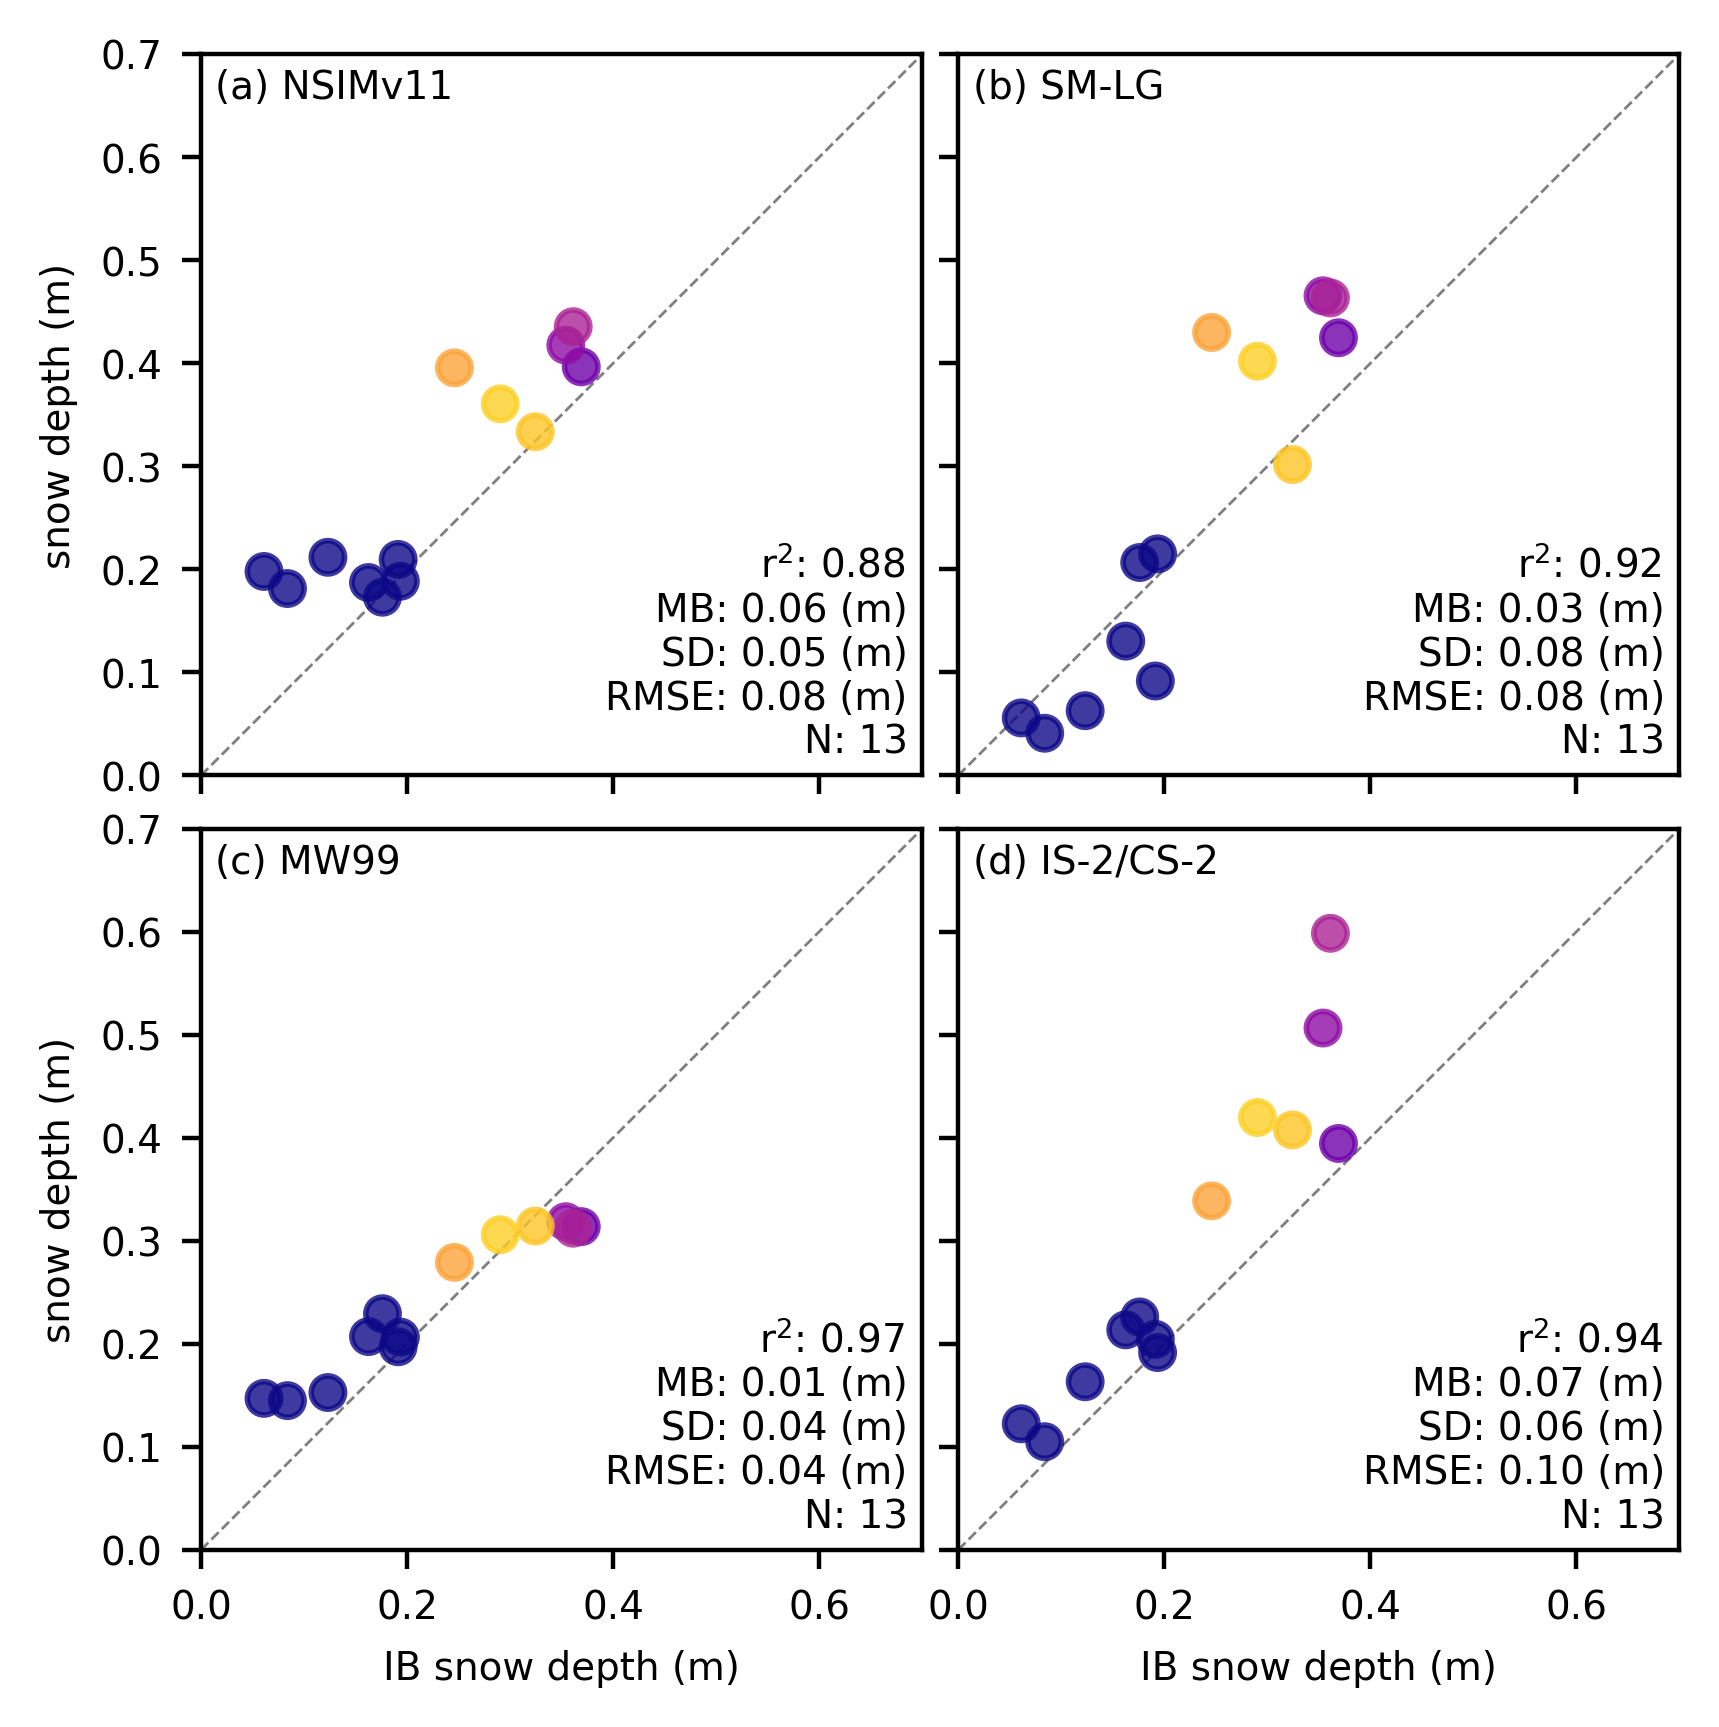

In [16]:
# Plot snow

snow_labels=['NSIMv11', 'SM-LG', 'MW99', 'IS-2/CS-2']  # Added fourth label
panel_labels = ['(a)', '(b)', '(c)', '(d)']  # Updated panel labels

fig, axes = plt.subplots(2, 2, figsize=(4.2, 4.2), gridspec_kw={'hspace': 0.05, 'wspace': 0.05})  # Changed to 2x2
axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

for i, option in enumerate(variables_snow):
    print(option)
    ax = axes[i]

    ax.scatter(validation_results_snow[option]['IB_comps'], validation_results_snow[option]['IS2_comps'], c=validation_results_snow[option]['IB_lon'], alpha=0.8, cmap='plasma_r', vmin=50, vmax=120)
    
    # Retrieve validation results for the current option
    r_str= validation_results_snow[option]['r_str']
    mb_str = validation_results_snow[option]['mb_str']
    sd_str = validation_results_snow[option]['sd_str']
    n_str =  str(len(validation_results_snow[option]['IS2_comps']))

    # Calculate RMSE for each ULS
    rmse = validation_results_snow[option]['rmse']

    # Annotate the plot with RMSE, mean bias, and standard deviation
    ax.annotate(f"r$^2$: {r_str} \nMB: {mb_str} (m)\nSD: {sd_str} (m)\nRMSE: {rmse} (m)\nN: {n_str}", color='k', xy=(0.98, 0.02), xycoords='axes fraction', horizontalalignment='right', verticalalignment='bottom', fontsize=7)

    # Combine panel label with option label
    ax.annotate(f"{panel_labels[i]} "+snow_labels[i], xy=(0.02, 0.98), xycoords='axes fraction', horizontalalignment='left', verticalalignment='top')

    # Set x and y labels only for the leftmost and bottom plots
    if (i==0):
        ax.legend(frameon=False, loc="upper right")
    if (i == 0 or i == 2):  # Changed to show y-labels for left column
        ax.set_ylabel('snow depth (m)')
    else:
        ax.set_yticklabels('')
    
    if (i == 2 or i == 3):  # Changed to show x-labels for bottom row
        ax.set_xlabel('IB snow depth (m)')
    else:
        ax.set_xticklabels('')

    ax.set_xlim([0, 0.7])
    ax.set_ylim([0, 0.7])
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    ax.plot(lims, lims, 'k--', linewidth=0.5, alpha=0.5, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)

plt.subplots_adjust(left=0.1, right=0.98, top=0.98, bottom=0.08)  # Adjust these values to reduce whitespace
plt.savefig('./figs/IB_4scatter_snow_inccs2_'+ib_agg_str+'_'+int_str+'_'+str(grid_size)+'km.pdf', dpi=300)
plt.show()